In [132]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import main
from patsy import dmatrices
import statsmodels.api as sm
from pandas.plotting import lag_plot

In [133]:
data = main.getdata('data/timeseries13May.csv')

In [134]:
data = data.loc[data['country'].isin(['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'])]

In [135]:
len(data['country'].unique())

10

Check if Spain still has negative value for 19 April (true for all data until 13 May)

In [136]:
data.loc[data['country']=='Spain']

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
14456,2019-12-31,31,12,2019,0,0,Spain,ES,ESP,46723749.0,Europe
14455,2020-01-01,1,1,2020,0,0,Spain,ES,ESP,46723749.0,Europe
14454,2020-01-02,2,1,2020,0,0,Spain,ES,ESP,46723749.0,Europe
14453,2020-01-03,3,1,2020,0,0,Spain,ES,ESP,46723749.0,Europe
14452,2020-01-04,4,1,2020,0,0,Spain,ES,ESP,46723749.0,Europe
14451,2020-01-05,5,1,2020,0,0,Spain,ES,ESP,46723749.0,Europe
14450,2020-01-06,6,1,2020,0,0,Spain,ES,ESP,46723749.0,Europe
14449,2020-01-07,7,1,2020,0,0,Spain,ES,ESP,46723749.0,Europe
14448,2020-01-08,8,1,2020,0,0,Spain,ES,ESP,46723749.0,Europe
14447,2020-01-09,9,1,2020,0,0,Spain,ES,ESP,46723749.0,Europe


In [137]:
data = data.drop([14346])

Show autocorrelation

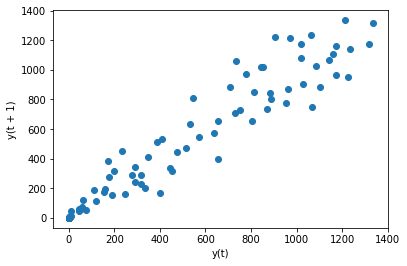

In [138]:
lag_plot(data.loc[data['country']=='Netherlands', 'cases'])
plt.show()

Add columns for cases of yesterday and predictions of yesterday. 

In [139]:
data = data.assign(expcasesyest=np.nan, casesyest=np.nan)

In [140]:
for country in data['country'].unique(): 
    data.loc[data['country']==country, 'casesyest'] = data.loc[data['country']==country].cases.shift(1)

In [141]:
data.head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp,expcasesyest,casesyest
16025,2019-12-31,31,12,2019,0,0,United_Kingdom,UK,GBR,66488991.0,Europe,NaN,NaN
4318,2019-12-31,31,12,2019,0,0,Denmark,DK,DNK,5797446.0,Europe,NaN,NaN
6090,2019-12-31,31,12,2019,0,0,Germany,DE,DEU,82927922.0,Europe,NaN,NaN
8149,2019-12-31,31,12,2019,0,0,Italy,IT,ITA,60431283.0,Europe,NaN,NaN
1751,2019-12-31,31,12,2019,0,0,Belgium,BE,BEL,11422068.0,Europe,NaN,NaN


Separate countries, reindex dataframes and set the first expcasesyest to 0. 

In [142]:
nl=no=be=ge=de=se=ro=it=uk=sp= None
countries = [[nl, 'Netherlands'], [no, 'Norway'], [be, 'Belgium'], [ge, 'Germany'], [de, 'Denmark'], [se, 'Sweden'], [ro, 'Romania'], [it, 'Italy'], [uk, 'United_Kingdom'], [sp, 'Spain']]
for country in countries: 
    country[0] = data.loc[data['country'] == country[1]]
    country[0].drop(country[0].loc[country[0]['cases']==0].index, inplace=True)
    country[0].reset_index(drop=True, inplace=True)
    country[0].loc[0,'expcasesyest']=0

In [143]:
dataframes, _ = zip(*countries)

Regression model based on https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958 and http://economiaweb.unipv.it/wp-content/uploads/2018/01/DEMWP0185.pdf. 

In [189]:
expr = """cases ~  (np.log(1+casesyest)) + (np.log(1+expcasesyest))"""
finalSummaries = []
paramsAll = []
for country in dataframes: 
    params = []
    for i in range(1, len(country)+1):
        
        mask = np.full(len(country), False)
        if i > 0: 
            mask[(i-1):i] = True
        else: 
            mask[0] = True
        y_train, X_train = dmatrices(expr, country[mask], return_type='dataframe')

        poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

        poisson_predictions = poisson_training_results.get_prediction(X_train)
        predictions_summary_frame = poisson_predictions.summary_frame()
        if (i < len(country)): 
            country.loc[i,'expcasesyest']=int(predictions_summary_frame['mean'].values[0])
        country.loc[i-1,'expcasestoday']=int(predictions_summary_frame['mean'].values[0])

        params.append([poisson_training_results.params[0], poisson_training_results.params[1], poisson_training_results.params[2]])
    
    paramsAll.append(params)
    finalSummaries.append([country.loc[0,['country']].values[0], poisson_training_results.summary()])

In [17]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  cases   No. Observations:                    1
Model:                            GLM   Df Residuals:                        0
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3.9793
Date:                Wed, 13 May 2020   Deviance:                   1.0081e-13
Time:                        14:20:45   Pearson chi2:                 4.54e-28
No. Iterations:                     1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Next steps:
* Plot daily predictions and true cases (expcasestoday and cases)

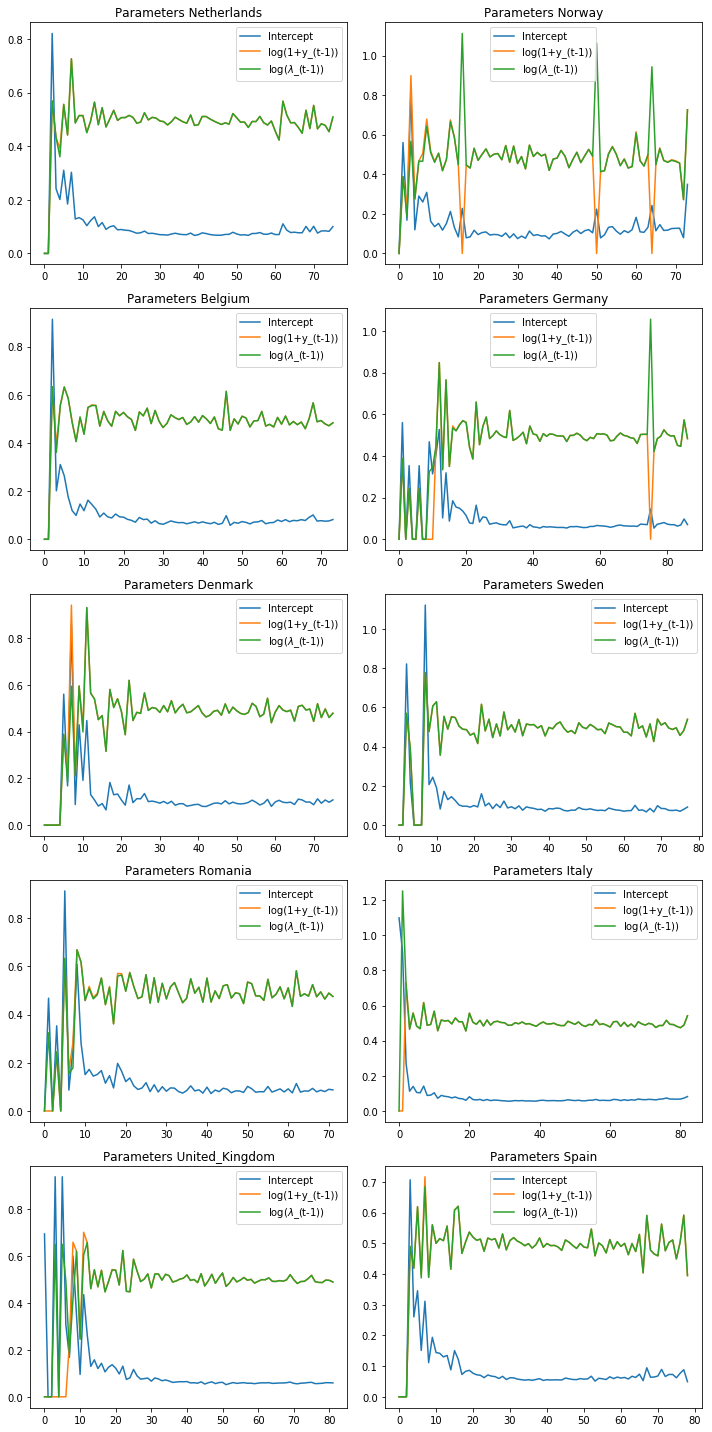

In [191]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for ax, parameters, country in zip(axes.ravel(), paramsAll, dataframes):
    ax.plot(parameters)
    ax.set_title('Parameters '+country.loc[0,['country']].values[0])
    ax.legend(['Intercept', 'log(1+y_(t-1))', 'log($\lambda$_(t-1))'])
#     ax.set_xlabel('Day')
#     ax.set_ylabel('Cases')
#     ax.set_xticklabels(country[['date']].values, rotation=90)

fig.tight_layout()

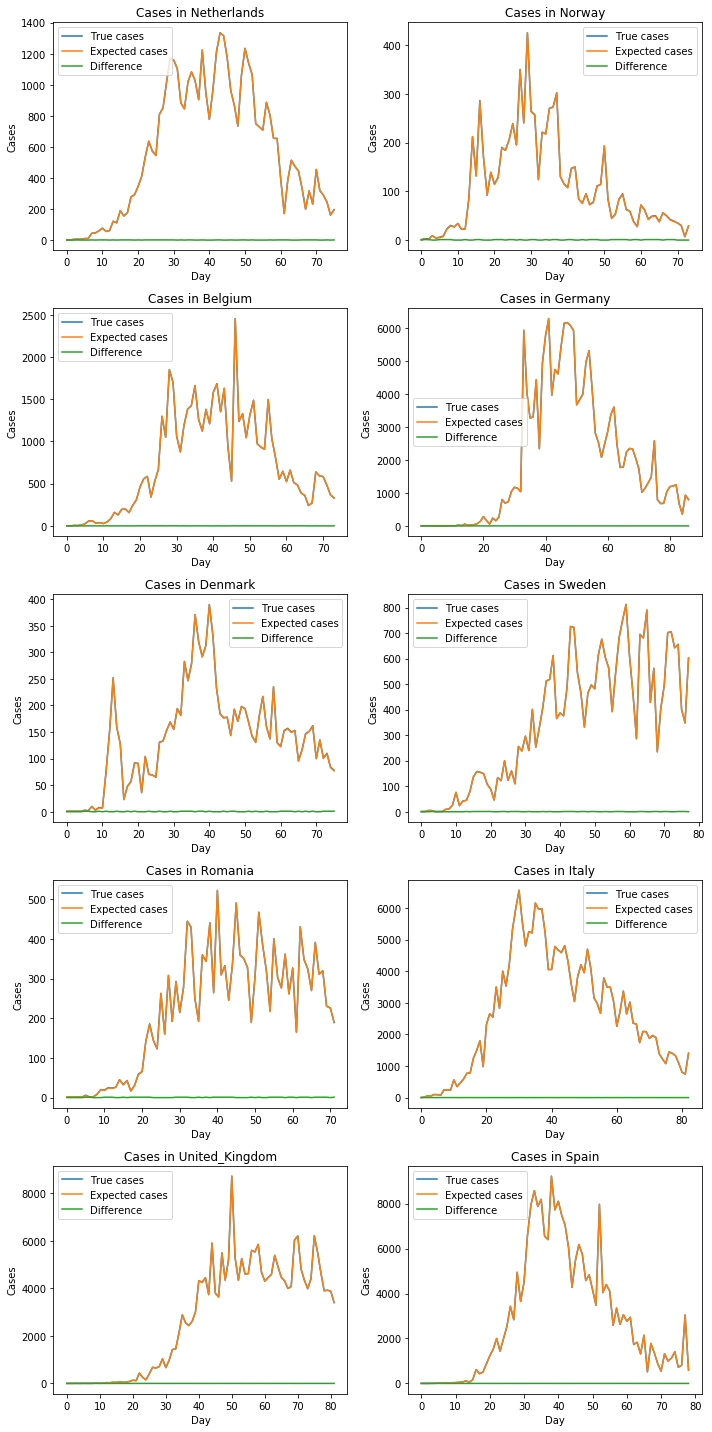

In [227]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for ax, country in zip(axes.ravel(), dataframes):
#     ax.plot(country[['cases']].values)
#     ax.plot(country[['expcasestoday']].values)
#     combcases = np.concatenate((country[['cases']].values,country[['expcasestoday']].values),axis=1).tolist()
#     ax.plot(combcases)
    ax.plot(country[['cases']].values)
    ax.plot(country[['expcasestoday']].values)
    ax.plot(country[['cases']].values-country[['expcasestoday']].values)
#     country.plot(y=['cases', 'expcasestoday'], ax=ax, legend=False)
#     country.plot(x='date', y='expcasestoday', ax=ax, legend=False)
#     country[['cases', 'expcasestoday']].plot()

#     ax = country.plot(y="cases")
#     country.plot(y="expcasestoday", ax=ax)

#     country.plot(x='date', y='cases')
    ax.set_title('Cases in '+country.loc[0,['country']].values[0])
    ax.set_xlabel('Day')
    ax.set_ylabel('Cases')
    ax.legend(['True cases', 'Expected cases', 'Difference'])
#     ax.set_xticklabels(country[['date']].values, rotation=90)

fig.tight_layout()

In [257]:
paramest = []
for parameters in paramsAll[0:5]: 
    paramest.append(np.median(parameters[30:], axis = 0))

In [260]:
coefficients = np.median(paramest, axis = 0)

In [282]:
for country in dataframes: 
    for i in range(1, len(country)):
        y = coefficients[0] + coefficients[1]*(np.log(1+ country.loc[i]['casesyest'])) + coefficients[2]*(np.log(1+ country.loc[i]['expcasesyest']))
        country.loc[i,'expcasesyestGLOBAL']=np.exp(y)
        country.loc[i-1,'expcasestodayGLOBAL']=np.exp(y)

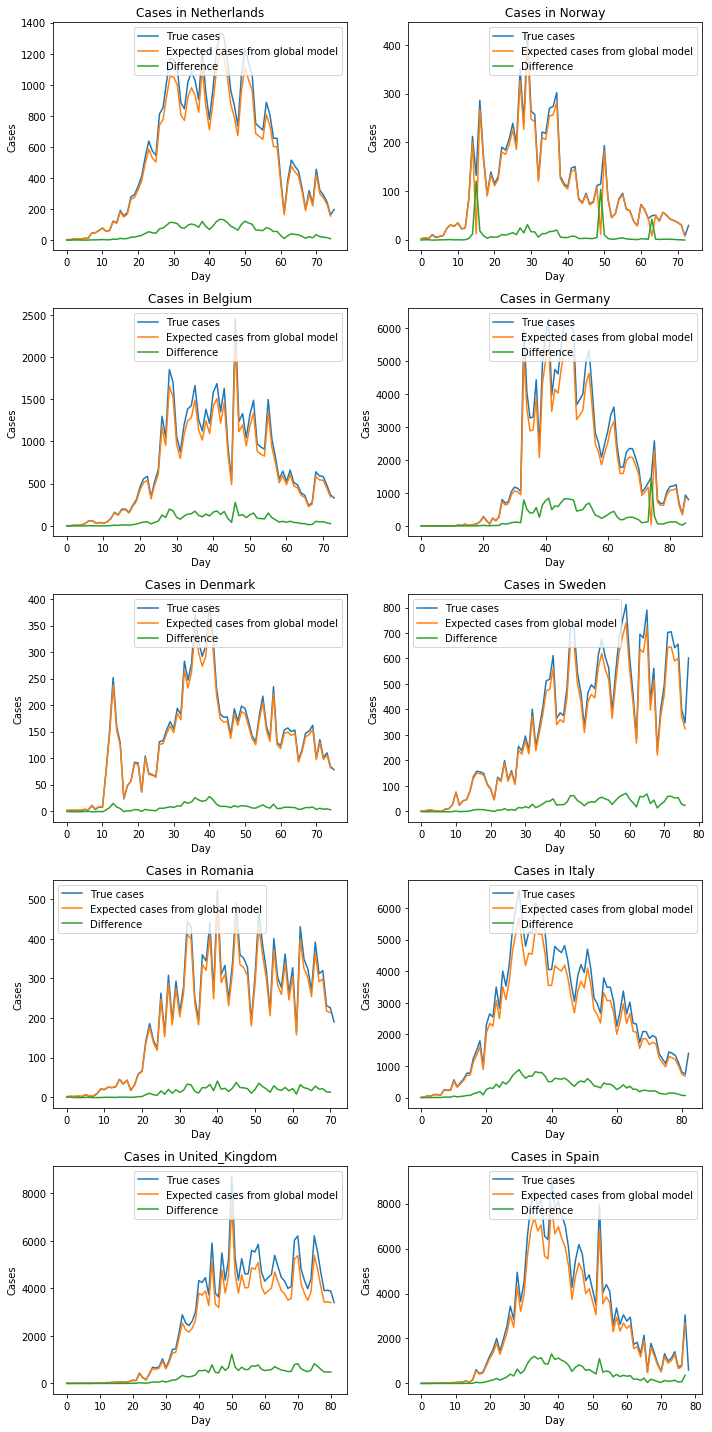

In [283]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for ax, country in zip(axes.ravel(), dataframes):
    ax.plot(country[['cases']].values)
    ax.plot(country[['expcasestodayGLOBAL']].values)
    ax.plot(country[['cases']].values-country[['expcasestodayGLOBAL']].values)

    ax.set_title('Cases in '+country.loc[0,['country']].values[0])
    ax.set_xlabel('Day')
    ax.set_ylabel('Cases')
    ax.legend(['True cases', 'Expected cases from global model', 'Difference'])

fig.tight_layout()